In [7]:
from dictionary_learning.dictionary import BatchTopKCrossCoder
from tiny_dashboard.dashboard_implementations import CrosscoderOnlineFeatureDashboard
from nnsight import LanguageModel
import torch
from transformer_lens import HookedTransformer

torch.set_grad_enabled(False)

In [8]:
gemma2 = HookedTransformer.from_pretrained_no_processing("google/gemma-2-2b")
gemma2_it = HookedTransformer.from_pretrained_no_processing("google/gemma-2-2b-it")

crosscoder = BatchTopKCrossCoder.from_pretrained("science-of-finetuning/gemma-2-2b-L13-k100-lr1e-04-local-shuffling-CCLoss", from_hub=True, device="cuda")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded pretrained model google/gemma-2-2b into HookedTransformer


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model google/gemma-2-2b-it into HookedTransformer


In [60]:
def activations_all_tokens(tokens):
    layer = 13
    hook_names = [f"blocks.{i}.hook_resid_post" for i in [layer]]
    _, cache = gemma2.run_with_cache(tokens, names_filter=hook_names)
    _, cache_it = gemma2_it.run_with_cache(tokens, names_filter=hook_names)

    l13_act_base = cache[f"blocks.{layer}.hook_resid_post"][0]
    l13_act_it = cache_it[f"blocks.{layer}.hook_resid_post"][0]

    return l13_act_base, l13_act_it

messages = [
    {"role": "user", "content": "I saw a sign that said \"watch for children\" and I thought, \"That sounds like a fair trade\""},
    {"role": "assistant", "content": ""}
]

prompt = gemma2_it.tokenizer.apply_chat_template(messages, return_tensors="pt")

l13_act_base, l13_act_it = activations_all_tokens(prompt)
crosscoder_input = torch.stack([l13_act_base, l13_act_it], dim=1)  # (seq, 2, 2304)

# Get reconstruction and features
_, features = crosscoder(crosscoder_input, output_features=True)

print(features[-10:, 50586])



tensor([ 0.0000,  0.0000,  0.0000, 53.5770,  0.0000, 60.3446, 26.6560, 32.6823,
         0.0000, 22.7112], device='cuda:0')


In [19]:
logits, cache = gemma2_it.run_with_cache(prompt)
decomposition, labels = cache.decompose_resid(layer=14, return_labels=True)
print(decomposition.shape)
print(labels)
print(cache["blocks.13.hook_resid_pre"].shape)


torch.Size([29, 1, 30, 2304])
['embed', '0_attn_out', '0_mlp_out', '1_attn_out', '1_mlp_out', '2_attn_out', '2_mlp_out', '3_attn_out', '3_mlp_out', '4_attn_out', '4_mlp_out', '5_attn_out', '5_mlp_out', '6_attn_out', '6_mlp_out', '7_attn_out', '7_mlp_out', '8_attn_out', '8_mlp_out', '9_attn_out', '9_mlp_out', '10_attn_out', '10_mlp_out', '11_attn_out', '11_mlp_out', '12_attn_out', '12_mlp_out', '13_attn_out', '13_mlp_out']
torch.Size([1, 30, 2304])
tensor([[[ 0.6860,  1.0977,  3.0149,  ..., -1.5590,  0.3709, -1.1333],
         [-4.4408,  3.4579,  0.7538,  ..., -0.7715, -1.7033,  0.6737],
         [-4.4387,  2.8743,  1.4596,  ...,  2.5471, -2.9258,  2.6699],
         ...,
         [ 3.0843, -0.7433,  0.3291,  ...,  3.9171,  2.8741,  1.1172],
         [ 2.9798, -0.8881, -0.4452,  ...,  0.5213,  1.2112,  0.0155],
         [ 4.0879,  0.4225,  0.0575,  ..., -0.2351,  1.1688,  3.0978]]],
       device='cuda:0')
tensor([[ 0.6860,  1.0977,  3.0149,  ..., -1.5590,  0.3709, -1.1333],
        [-4.

In [121]:
feature = 50586

def get_feature_preact(model_act, encoder, feature):
    return(model_act @ crosscoder.encoder.weight[encoder, :, feature]) * crosscoder.get_sparsity_loss_weight()[0, feature]
    

_, cache = gemma2.run_with_cache(prompt)
_, cache_it = gemma2_it.run_with_cache(prompt)


decomposition, labels = cache.decompose_resid(14, return_labels=True)
decomposition_it, labels = cache_it.decompose_resid(14, return_labels=True)


tensor(-2.5891, device='cuda:0')
tensor(56.1990, device='cuda:0')


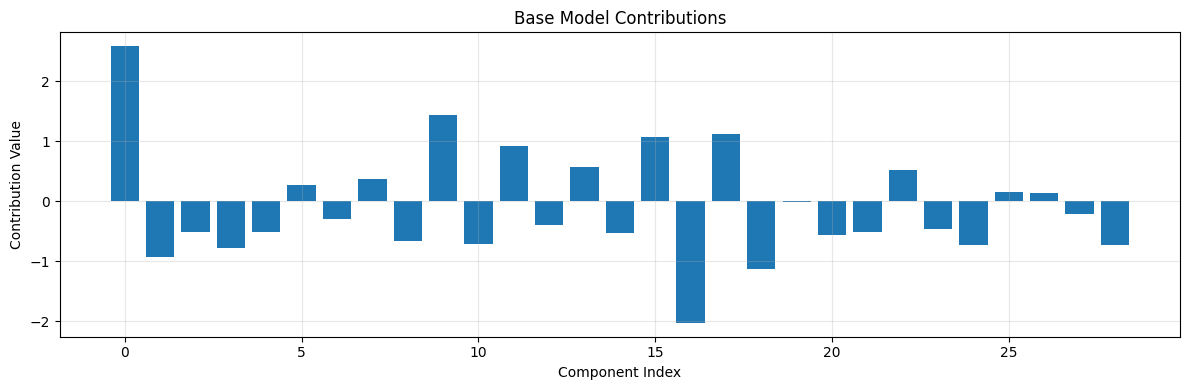

Top 5 components with largest contributions (Base Model):
Component 0 (embed): 2.5832
Component 16 (7_mlp_out): -2.0276
Component 9 (4_attn_out): 1.4351
Component 17 (8_attn_out): 1.1241
Component 18 (8_mlp_out): -1.1229


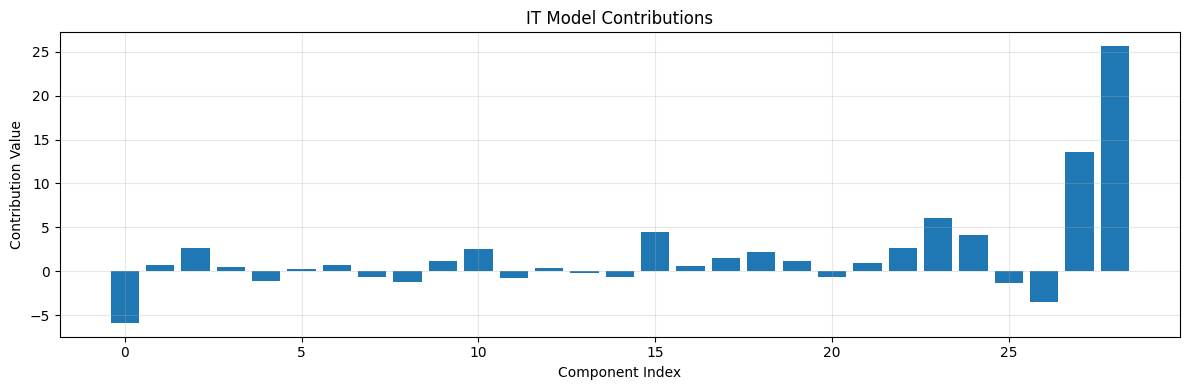

Top 5 components with largest contributions (IT Model):
Component 28 (13_mlp_out): 25.6132
Component 27 (13_attn_out): 13.5726
Component 23 (11_attn_out): 6.0832
Component 0 (embed): -5.8524
Component 15 (7_attn_out): 4.4905


In [114]:

contribs_base = []
contribs_it = []
for (component_output, component_output_it) in zip(decomposition, decomposition_it):
    contrib_base = get_feature_preact(component_output, 0, feature)
    contribs_base.append(contrib_base[0, -7])
    contrib_it = get_feature_preact(component_output_it, 1, feature)
    contribs_it.append(contrib_it[0, -7])

print(sum(contribs_base))
print(sum(contribs_it))

import matplotlib.pyplot as plt

def plot_contributions(contributions, title, labels=None, top_n=5):
    # Move tensors to CPU before plotting
    contribs_cpu = [contrib.cpu().item() if hasattr(contrib, 'cpu') else contrib for contrib in contributions]
    
    # Create the plot
    plt.figure(figsize=(12, 4))
    plt.bar(range(len(contribs_cpu)), contribs_cpu)
    plt.title(f'{title} Contributions')
    plt.xlabel('Component Index')
    plt.ylabel('Contribution Value')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print the components with the largest absolute contributions
    if labels is not None:
        print(f"Top {top_n} components with largest contributions ({title}):")
        top_indices = sorted(range(len(contribs_cpu)), key=lambda i: abs(contribs_cpu[i]), reverse=True)[:top_n]
        for i in top_indices:
            print(f"Component {i} ({labels[i]}): {contribs_cpu[i]:.4f}")

# Plot for base model
plot_contributions(contribs_base, "Base Model", labels)

# Plot for IT model
plot_contributions(contribs_it, "IT Model", labels)



In [120]:
hook_name = "blocks.13.attn.hook_z"

from functools import partial

_, cache_base = gemma2.run_with_cache(prompt)

def ablate_head_hook(value, hook, head, pos):
    value[:, pos, head, :] *= 0
    return value

def patch_base_hook(value, hook, pos):
    value[:, pos, :] = cache_base[hook.name][:, pos, :]
    return value
    
for i in range(gemma2_it.cfg.n_heads):
    with gemma2_it.hooks([(hook_name, partial(ablate_head_hook, pos=-5, head=i))]):
        _, cache_it_ablated = gemma2_it.run_with_cache(prompt)
        _, features = crosscoder(torch.stack([l13_act_base, cache["blocks.13.hook_resid_post"][0]], dim=1), output_features=True)
        print(features[-10:, feature])


tensor([ 0.0000,  0.0000,  0.0000, 56.5144,  0.0000, 60.3446, 26.6560, 32.6823,
         0.0000, 22.7112], device='cuda:0')
tensor([ 0.0000,  0.0000,  0.0000, 56.5144,  0.0000, 60.3446, 26.6560, 32.6823,
         0.0000, 22.7112], device='cuda:0')
tensor([ 0.0000,  0.0000,  0.0000, 56.5144,  0.0000, 60.3446, 26.6560, 32.6823,
         0.0000, 22.7112], device='cuda:0')
tensor([ 0.0000,  0.0000,  0.0000, 56.5144,  0.0000, 60.3446, 26.6560, 32.6823,
         0.0000, 22.7112], device='cuda:0')
tensor([ 0.0000,  0.0000,  0.0000, 56.5144,  0.0000, 60.3446, 26.6560, 32.6823,
         0.0000, 22.7112], device='cuda:0')
tensor([ 0.0000,  0.0000,  0.0000, 56.5144,  0.0000, 60.3446, 26.6560, 32.6823,
         0.0000, 22.7112], device='cuda:0')
tensor([ 0.0000,  0.0000,  0.0000, 56.5144,  0.0000, 60.3446, 26.6560, 32.6823,
         0.0000, 22.7112], device='cuda:0')
tensor([ 0.0000,  0.0000,  0.0000, 56.5144,  0.0000, 60.3446, 26.6560, 32.6823,
         0.0000, 22.7112], device='cuda:0')


In [6]:
messages = [
    {"role": "user", "content": "It's hard to explain puns to kleptomaniacs because they always take things literally."},
    {"role": "assistant", "content": ""}
]

prompt = gemma2_it.tokenizer.apply_chat_template(messages, return_tensors="pt")

# get residual stream activations from both models on layer 13

l3_act_base_tl, l3_act_it_tl = activations_all_tokens(prompt)
input = torch.stack([l3_act_base_tl, l3_act_it_tl], dim=1)

# get the crosscoder activations
_, activations = crosscoder(input, output_features=True)

print(input.shape)
print(activations.shape)

for (i, pos) in enumerate(activations):
    # Print the token at position i
    token_id = prompt[0, i].item()
    token = gemma2_it.tokenizer.decode([token_id])
    print(f"Position {i}, Token: {repr(token)}, activations: {pos[50586]}")



torch.Size([30, 2, 2304])
torch.Size([30, 73728])
Position 0, Token: '<bos>', activations: 0.0
Position 1, Token: '<start_of_turn>', activations: 0.0
Position 2, Token: 'user', activations: 0.0
Position 3, Token: '\n', activations: 0.0
Position 4, Token: 'It', activations: 0.0
Position 5, Token: "'", activations: 0.0
Position 6, Token: 's', activations: 0.0
Position 7, Token: ' hard', activations: 0.0
Position 8, Token: ' to', activations: 0.0
Position 9, Token: ' explain', activations: 0.0
Position 10, Token: ' puns', activations: 7.6704301834106445
Position 11, Token: ' to', activations: 0.0
Position 12, Token: ' kle', activations: 0.0
Position 13, Token: 'pto', activations: 0.0
Position 14, Token: 'mani', activations: 0.0
Position 15, Token: 'acs', activations: 0.0
Position 16, Token: ' because', activations: 0.0
Position 17, Token: ' they', activations: 0.0
Position 18, Token: ' always', activations: 0.0
Position 19, Token: ' take', activations: 0.0
Position 20, Token: ' things', a